In [2]:
import argparse
import torch
import os

from PIL import Image

import os
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as T
from tqdm.notebook import tqdm

transform = T.ToPILImage()
import torch.optim as optim
import json
import numpy as np
import torch.nn.functional as F
import torchaudio
import torch.nn as nn
import imagebind.data as data
from IPython.display import Audio
import torchvision
from torchvision.transforms import transforms


/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' m

In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [4]:

import torch
import torchaudio
import torchaudio.transforms as T
from IPython.display import Audio


# Parameters
num_mel_bins = 128
num_frames = 204
sample_rate = 16000
n_fft = 400
hop_length = n_fft//4
win_length = n_fft

# Function to create a Mel inversion matrix
def create_mel_inversion_matrix(sr, n_fft, n_mels, fmin=0.0, fmax=None):
    # Create a Mel filter bank using torchaudio
    mel_fb = T.MelScale(n_mels, sr, f_min=fmin, f_max=fmax, n_stft=n_fft//2+1, norm=None)
    # Convert the filter bank to a tensor
    mel_fb_tensor = torch.tensor(mel_fb.fb, dtype=torch.float)
    # Calculate the pseudo inverse
    inversion_matrix = torch.pinverse(mel_fb_tensor)
    print(inversion_matrix.shape)
    
    return inversion_matrix

def inverse_it(mel_spectrogram):
    
    # Create the Mel inversion matrix
    inversion_matrix = create_mel_inversion_matrix(sample_rate, n_fft, num_mel_bins)

    # Invert the Mel spectrogram to a power spectrogram
    power_spectrogram = torch.matmul(mel_spectrogram, inversion_matrix)

    # Create an InverseMelScale transform
    inverse_mel_scale_transform = T.InverseMelScale(
        n_stft=n_fft//2+1,
        n_mels=num_mel_bins,
        sample_rate=sample_rate,
        f_min=0.0,
        f_max=sample_rate//2,
        norm=None
    )

    # Apply the InverseMelScale transform to the Mel spectrogram
    spectrogram = inverse_mel_scale_transform(mel_spectrogram.T)

    # Initialize Griffin-Lim transform
    griffin_lim = T.GriffinLim(n_fft=n_fft, n_iter=32, win_length=win_length, hop_length=hop_length)

    # Recover the waveform from the spectrogram
    recovered_waveform = griffin_lim(spectrogram)
    
    Audio(recovered_waveform, rate=16000)
    
    return recovered_waveform

def inverse_normalize(melspec, mean=-4.268, std=9.138):
    return melspec * std + mean


def combine_results(audio):
    results = list()
    for i in range(audio.shape[1]):
        res = inverse_it(inverse_normalize(audio.clone().detach().cpu().float()[0][i][0]).T)
        results.append(res)
    # return [results[0], results[1], results[2]]
    return [results[0][:-5000], results[1][:-5000], results[2][:-2000]]
    
from pydub import AudioSegment
import os

def get_results(audio_tensor):
    mel_spectrogram_np = audio_tensor[0, :, 0, :, :198].detach().clone().cpu().float()
    audio_cropped = torch.cat(tuple(mel_spectrogram_np), dim=-1)
    return inverse_it(inverse_normalize(audio_cropped.T))


def convert_mp3_to_wav(input_path, output_path, bitrate, duration, shift=0):
    # Load the MP3 file
    audio = AudioSegment.from_mp3(input_path)
    print(len(audio))
    # Set the desired duration
    audio = audio[shift:duration * 1000 + shift]

    # Set the desired bitrate
    audio = audio.set_frame_rate(bitrate)

    # Export the audio as a WAV file
    audio.export(output_path, format='wav')
    return audio

 

In [5]:
def custom_loader(path):
    image_tensor = data.load_and_transform_vision_data([path], 'cpu')
    return image_tensor

In [6]:
dataset = torchvision.datasets.ImageNet('/home/eugene/data/imagenet/', split='val', loader=custom_loader)

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
test_transform = transforms.Compose([
            # transforms.Resize(256),
            # transforms.CenterCrop(224),
            transforms.Resize(132),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            normalize,
            
        ])

In [8]:
unnorm = UnNormalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


In [9]:
len(dataset)

50000

In [10]:
device = 'cuda:2'
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType



# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)
0

0

In [11]:
all_embeds = list()

In [12]:
for i in tqdm(range(50000)):
    image_tensor, _ = dataset[i]
    with torch.no_grad():
        embed = model({'vision': image_tensor.to(device)})
        all_embeds.append(embed['vision'].cpu())

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
catted_embeds = torch.cat(all_embeds, dim=0)

In [41]:
catted_embeds.shape

torch.Size([50000, 1024])

In [43]:
cos_sim =torch.zeros([50000, 50000], dtype=torch.float16)

In [50]:
del cos_sim

In [44]:
s = catted_embeds[:10]
z = catted_embeds[10:20]

In [ ]:
for i, x in enumerate(dataset.classes):
    for entry in x:
        if 'sheep' in entry:
            print(i, x)
            break

In [136]:
for i, x in enumerate(dataset.classes):
    for entry in x:
        if 'sheep' in entry:
            print(i, x)
            break

229 ('Old English sheepdog', 'bobtail')
230 ('Shetland sheepdog', 'Shetland sheep dog', 'Shetland')
349 ('bighorn', 'bighorn sheep', 'cimarron', 'Rocky Mountain bighorn', 'Rocky Mountain sheep', 'Ovis canadensis')


In [153]:
for i, (lbl) in enumerate(dataset.targets):
    if lbl == 348:
        print(i)

17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449


In [276]:
dataset.classes[348]

('ram', 'tup')

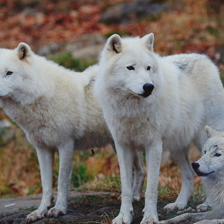

In [288]:
transform(unnorm(dataset[270*50 + 4][0][0]))

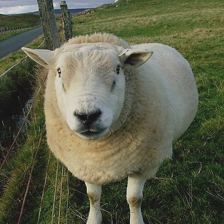

In [155]:
transform(unnorm(dataset[17439][0][0]))

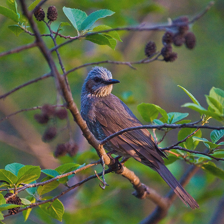

In [123]:
transform(unnorm(dataset[838][0][0]))

In [199]:
mean_embeds = torch.zeros( [len(dataset.classes), 1024])
test_embeds = torch.zeros( [5000, 1024])
test_labels = torch.ones( [5000])

In [73]:
len(dataset)

50000

In [76]:
catted_embeds[ 50*(i+1)-2: 50*(i+1)].shape

torch.Size([2, 1024])

In [200]:
for i in range(len(dataset.classes)):
    mean_embeds[i] = torch.mean(catted_embeds[ 50*i: 50*(i+1)-5] , dim=0)
    test_embeds[5*i: 5*(i+1)] = catted_embeds[ 50*(i+1) - 5 : 50*(i+1)]
    test_labels[5*i: 5*(i+1)] = i
        

In [196]:
test_embeds

torch.Size([5000, 1024])

In [84]:
mean_embeds.shape

torch.Size([1000, 1024])

In [91]:
torch.tensordot(test_embeds, mean_embeds.T, dims=1)

tensor([[0.7379, 0.4263, 0.3436,  ..., 0.3759, 0.3444, 0.2496],
        [0.4907, 0.7358, 0.4501,  ..., 0.4096, 0.4526, 0.3662],
        [0.4246, 0.4936, 0.7515,  ..., 0.3580, 0.4315, 0.3360],
        ...,
        [0.3422, 0.3700, 0.3544,  ..., 0.6977, 0.4758, 0.3283],
        [0.3860, 0.4334, 0.3619,  ..., 0.4560, 0.5988, 0.3006],
        [0.2944, 0.3645, 0.3053,  ..., 0.3662, 0.3367, 0.4477]])

In [201]:
res = test_embeds @ mean_embeds.T
res.shape

torch.Size([5000, 1000])

In [202]:
_, max_indices = torch.max(res, dim=1)


In [204]:
(max_indices == test_labels).sum()/5000

tensor(0.7100)

In [70]:
alligators = torch.mm(catted_embeds[2500:2550], catted_embeds[2500:2550].T)

tensor([[1.0000, 0.7681, 0.7079,  ..., 0.7891, 0.7641, 0.7543],
        [0.7681, 1.0000, 0.6405,  ..., 0.7534, 0.8608, 0.8027],
        [0.7079, 0.6405, 1.0000,  ..., 0.7846, 0.6075, 0.6192],
        ...,
        [0.7891, 0.7534, 0.7846,  ..., 1.0000, 0.7473, 0.7177],
        [0.7641, 0.8608, 0.6075,  ..., 0.7473, 1.0000, 0.8673],
        [0.7543, 0.8027, 0.6192,  ..., 0.7177, 0.8673, 1.0000]])

In [49]:
torch.matmul(s,z.T)

tensor([[0.5879, 0.5797, 0.6404, 0.6300, 0.6104, 0.6782, 0.7252, 0.6770, 0.5770,
         0.6260],
        [0.5607, 0.7233, 0.7756, 0.7748, 0.6178, 0.7506, 0.8172, 0.7668, 0.7044,
         0.7548],
        [0.4277, 0.6997, 0.7103, 0.7087, 0.7084, 0.5711, 0.6258, 0.5981, 0.7521,
         0.7198],
        [0.5126, 0.8129, 0.8595, 0.8354, 0.7481, 0.6876, 0.7363, 0.7330, 0.8541,
         0.8577],
        [0.5139, 0.7398, 0.7925, 0.7764, 0.6712, 0.7724, 0.8680, 0.8052, 0.7293,
         0.7647],
        [0.6058, 0.7357, 0.7998, 0.8196, 0.6223, 0.7691, 0.8235, 0.7930, 0.7299,
         0.7651],
        [0.4572, 0.8137, 0.8309, 0.7892, 0.7556, 0.6816, 0.7104, 0.6774, 0.8243,
         0.8295],
        [0.4800, 0.7698, 0.7662, 0.7156, 0.9236, 0.6769, 0.7029, 0.7003, 0.7036,
         0.7231],
        [0.4774, 0.7728, 0.7468, 0.7482, 0.9365, 0.6146, 0.6482, 0.6361, 0.6836,
         0.7430],
        [0.4224, 0.7342, 0.7753, 0.7216, 0.7818, 0.6419, 0.7190, 0.6313, 0.7654,
         0.6913]])

In [144]:
(audio_embed.cpu() @ mean_embeds.T).max(dim=1)

torch.return_types.max(
values=tensor([7.7189]),
indices=tensor([270]))

In [16]:
(audio_embed.cpu() @ catted_embeds.T).max(dim=1)

torch.return_types.max(
values=tensor([9.9267]),
indices=tensor([13535]))

In [17]:
dataset.classes[270]

('white wolf', 'Arctic wolf', 'Canis lupus tundrarum')

In [18]:
dataset.classes[17439]

IndexError: list index out of range

In [15]:

# text_list=["Everything we see hides another thing, we always want to see what is hidden by what we see, but it is impossible.",]
# image_paths=[".assets/car_image.jpg"] #".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]
# image_paths = ['horse.jpg']
audio_paths=["all_assets/wolves.wav"] #"all_assets/police3.wav"] # ".assets/car_audio.wav", ".assets/bird_audio.wav"

# Load data
inputs = {
    # ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    # ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

with torch.no_grad():
    # embeddings = imagebind(inputs)
    # text_embed = model.forward( {ModalityType.TEXT: data.load_and_transform_text(text_list, device)}, normalize=False)[ModalityType.TEXT] 
    audio_embed = model.forward( {ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device)}, normalize=False)[ModalityType.AUDIO]
    # image_embed = model.forward({ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device)}, normalize=False)[ModalityType.VISION]


In [20]:
path = "/home/eugene/ImageBind/all_assets/wolves.wav"
orig_waveform, sr = torchaudio.load(path)
print(sr)
audio_tensor = data.load_and_transform_audio_data([path], 'cpu', )
# Audio(torch.cat(combine_results(audio_tensor)), rate=16000)
# Audio(orig_waveform, rate=sr)

16000


In [21]:
X = audio_tensor.clone().detach().to(device).requires_grad_(True)

In [22]:
ideal_embed = catted_embeds[17439].to(device)

In [23]:
epochs = 20000
optimizer = optim.SGD([X], lr=0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = 1e-5) # Minimum learning rate.

In [179]:
pbar = tqdm(range(epochs))


for i in pbar:
    lr = scheduler.get_last_lr()[0]

    embeds = model.forward({'audio': X}, normalize=True)
    
    # loss = crit(embeds['vision'], ideal_embed)
    loss = 1 - F.cosine_similarity(embeds['audio'], ideal_embed, dim=1).mean()    
    
    res3 = torch.autograd.grad(outputs=loss, inputs=X)
    X = X - lr * res3[0].sign()
    # X = torch.clamp(X, min=-1.28, max=1.17)

    
    pbar.set_postfix({'loss': loss.item(), 'lr': lr})


    scheduler.step()

    del res3, embeds, loss
    



  0%|          | 0/20000 [00:00<?, ?it/s]

/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
X = 0.0001 * torch.rand_like(audio_tensor).to(device)
X.requires_grad_(True)
audio_tensor = audio_tensor.to(device)
0

0

In [25]:
epochs = 20000
optimizer = optim.SGD([X], lr=0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = 1e-5) # Minimum learning rate.

In [26]:
pbar = tqdm(range(epochs))
saved_dict = dict()
torch.save((audio_tensor).cpu(), f'hack/mul/dogs_loss_orig.pt')

for i in pbar:
    lr = scheduler.get_last_lr()[0]

    embeds = model.forward({'audio': X + audio_tensor}, normalize=True)
    
    # loss = crit(embeds['vision'], ideal_embed)
    loss = 1 - F.cosine_similarity(embeds['audio'], ideal_embed, dim=1).mean()
    res3 = torch.autograd.grad(outputs=loss, inputs=X)

    # if (val := round(loss.item() * 10)) not in saved_dict or i==0:
    #     saved_dict[val] = True
    #     torch.save((X.detach() + audio_tensor).cpu(), f'hack/mul/dogs_loss_{10-val}.pt')
    
    X = X - lr * res3[0].sign()
    # X =  X / X.norm()
    X.detach().clamp_(min=-0.05, max=0.05)

    
    pbar.set_postfix({'loss': loss.item(), 'lr': lr, 'norm': X.detach().norm().item(), 'saved': list(saved_dict.keys())})
    
        

    scheduler.step()

    del res3, embeds, loss
    
# torch.save((X.detach() + audio_tensor).cpu(), f'hack/mul/dogs_loss_last.pt')


  0%|          | 0/20000 [00:00<?, ?it/s]

/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [27]:
(model.forward({'audio': (audio_tensor + X).detach()}, normalize=True)['audio'].detach().cpu() @ catted_embeds.T).max(dim=1)

torch.return_types.max(
values=tensor([8.8510]),
indices=tensor([17439]))

In [180]:
(model.forward({'audio': X}, normalize=True)['audio'].detach().cpu() @ catted_embeds.T).max(dim=1)

torch.return_types.max(
values=tensor([6.3300]),
indices=tensor([17439]))

In [182]:
(model.forward({'audio': audio_tensor.to(device)}, normalize=True)['audio'].detach().cpu() @ mean_embeds.T).max(dim=1)

torch.return_types.max(
values=tensor([5.1561]),
indices=tensor([270]))

In [208]:
embeds = model.forward({'audio': audio_tensor.to(device)}, normalize=True)['audio'].detach()

In [209]:
embeds @ ideal_embed

tensor([3.2511], device='cuda:1')

In [42]:
torch.save(catted_embeds, 'embeds.pt')

In [13]:
catted_embeds = torch.load('embeds.pt')

In [14]:
import imagebind.data as data

In [1]:
X.shape

NameError: name 'X' is not defined

In [212]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [264]:
mel_spectrogram_np = audio_tensor.detach().cpu().squeeze(0).numpy()

# Split the 3 channels


In [268]:
mel_spectrogram_np = audio_tensor[0, :, 0, :, :198].detach().cpu()
channel_1, channel_2, channel_3 = mel_spectrogram_np

torch.Size([128, 594])

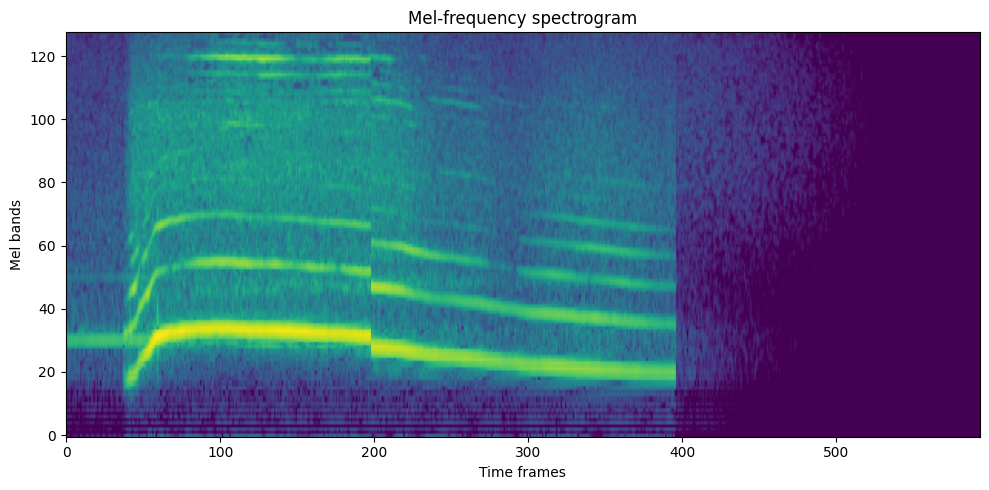

In [270]:
# Plot each of the 3 mel-spectrograms
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.imshow(torch.cat(tuple(mel_spectrogram_np), dim=-1), aspect='auto', origin='lower', cmap='viridis')
ax.set_title(f'Mel-frequency spectrogram')
ax.set_ylabel('Mel bands')
# ax[i].colorbar()

ax.set_xlabel('Time frames')
plt.tight_layout()
plt.show()

In [273]:
Audio(get_results(audio_tensor), rate=16000)

/tmp/ipykernel_3476713/1986768774.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_fb_tensor = torch.tensor(mel_fb.fb, dtype=torch.float)


torch.Size([128, 201])


In [274]:
Audio(get_results(X), rate=16000)

/tmp/ipykernel_3476713/1986768774.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_fb_tensor = torch.tensor(mel_fb.fb, dtype=torch.float)


torch.Size([128, 201])


In [28]:
torch.save((X + audio_tensor).detach().cpu(), 'hack/audio_wolves_to_sheep2.pt')

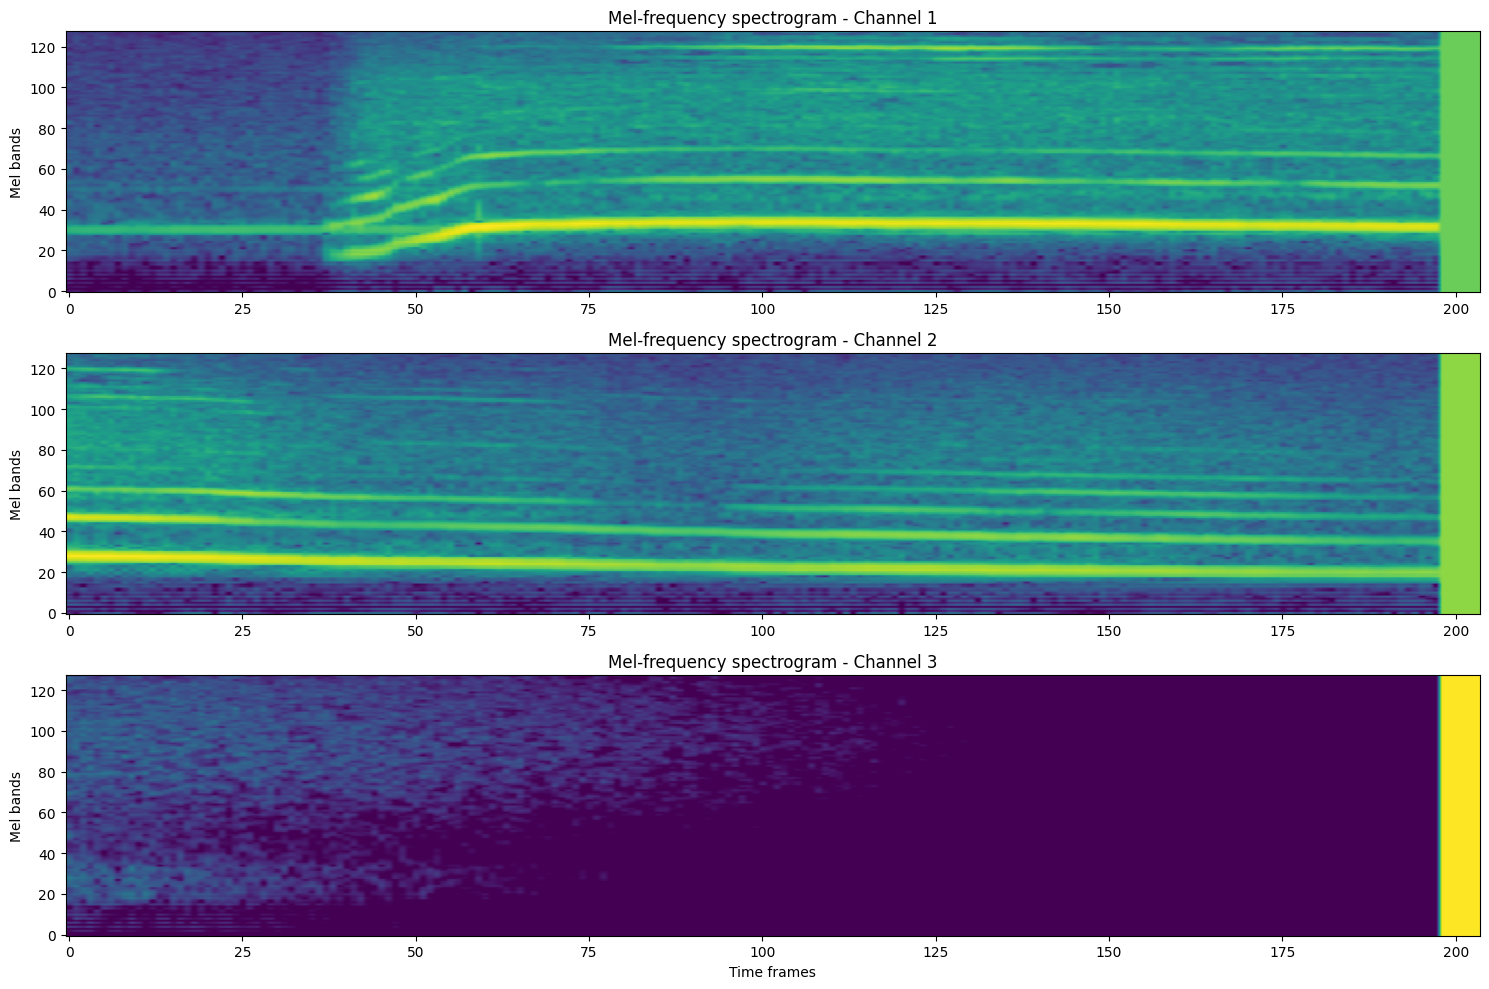

In [220]:
# Plot each of the 3 mel-spectrograms
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

    ax[i].imshow(mel_spectrogram_np[i, 0], aspect='auto', origin='lower', cmap='viridis')
    ax[i].set_title(f'Mel-frequency spectrogram - Channel {i+1}')
    ax[i].set_ylabel('Mel bands')
    # ax[i].colorbar()

ax[-1].set_xlabel('Time frames')
plt.tight_layout()
plt.show()

In [15]:
tmp_loader = dataset.loader

In [13]:
dataset.loader = custom_loader

<function torchvision.datasets.folder.default_loader(path: str) -> Any>

In [21]:
dataset[0][0].shape

torch.Size([1, 3, 224, 224])

In [7]:
dataset.classes

[('tench', 'Tinca tinca'),
 ('goldfish', 'Carassius auratus'),
 ('great white shark',
  'white shark',
  'man-eater',
  'man-eating shark',
  'Carcharodon carcharias'),
 ('tiger shark', 'Galeocerdo cuvieri'),
 ('hammerhead', 'hammerhead shark'),
 ('electric ray', 'crampfish', 'numbfish', 'torpedo'),
 ('stingray',),
 ('cock',),
 ('hen',),
 ('ostrich', 'Struthio camelus'),
 ('brambling', 'Fringilla montifringilla'),
 ('goldfinch', 'Carduelis carduelis'),
 ('house finch', 'linnet', 'Carpodacus mexicanus'),
 ('junco', 'snowbird'),
 ('indigo bunting', 'indigo finch', 'indigo bird', 'Passerina cyanea'),
 ('robin', 'American robin', 'Turdus migratorius'),
 ('bulbul',),
 ('jay',),
 ('magpie',),
 ('chickadee',),
 ('water ouzel', 'dipper'),
 ('kite',),
 ('bald eagle', 'American eagle', 'Haliaeetus leucocephalus'),
 ('vulture',),
 ('great grey owl', 'great gray owl', 'Strix nebulosa'),
 ('European fire salamander', 'Salamandra salamandra'),
 ('common newt', 'Triturus vulgaris'),
 ('eft',),
 ('spo